# Robustness curves for binary toy classification problem

In [ ]:
import os
os.chdir("../")
import sys
import json
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set(context='paper')

from utils import NumpyEncoder

## Plot settings:

In [2]:
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 26

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('text', usetex=True)

# dictionary that maps color string to 'good looking' seaborn colors that are easily distinguishable
colors = {
    "orange": sns.xkcd_rgb["yellowish orange"],
    "red": sns.xkcd_rgb["pale red"],
    "green": sns.xkcd_rgb["medium green"],
    "blue": sns.xkcd_rgb["denim blue"],
    "yellow": sns.xkcd_rgb["amber"],
    "purple": sns.xkcd_rgb["dusty purple"],
    "cyan": sns.xkcd_rgb["cyan"]
}

## Calculate data:

Runtime: < 10 minutes

In [3]:
data_path = 'res/toy_data.npz'

if os.path.exists(data_path):
    
    np_data = np.load(data_path)
    points = np_data['points']
    labels = np_data['labels']
    dists_l1 = np_data['dists_l1']
    dists_linf = np_data['dists_linf']
    dists_l2 = np_data['dists_l2']
    X = np_data['X']
    Y = np_data['Y']
    probs = np_data['probs']
    
else:

    if not os.path.exists("res"):
        os.makedirs("res")

    X = np.linspace(-2 * np.pi, 2 * np.pi, 1000)
    Y = np.sin(X)
    boundary = np.vstack((X, Y))

    n = 1000000
    r_points = np.random.rand(n, 2)
    r_points[:, 0] *= 4 * np.pi
    r_points[:, 0] -= 2 * np.pi
    r_points[:, 1] *= 4.5
    r_points[:, 1] -= 2.25

    def min_dist(point, boundary, p):
        difs = point.reshape(2, 1) - boundary
        distances = np.linalg.norm(difs, axis=0, ord=p)
        return np.min(distances)

    dists_l2 = np.zeros(n)

    for i, p in enumerate(r_points):
        dists_l2[i] = min_dist(p, boundary, 2)

    chosen = np.all([dists_l2 < 1.001, dists_l2 > 0.999], axis=0)
    points = r_points[chosen, :]
    dists_l2 = dists_l2[chosen]
    labels = np.array([y < np.sin(x) for (x, y) in points])
    n_points = np.count_nonzero(chosen)

    dists_l1 = np.zeros(n_points)
    dists_linf = np.zeros(n_points)
    for i, p in enumerate(points):
        dists_l1[i] = min_dist(p, boundary, 1)
        dists_linf[i] = min_dist(p, boundary, np.inf)

    add = [0, 1.1 * np.max(dists_l1)]
    dists_l1 = np.append(dists_l1, add)
    dists_l2 = np.append(dists_l2, add)
    dists_linf = np.append(dists_linf, add)

    dists_l1 = np.sort(dists_l1)
    dists_linf = np.sort(dists_linf)
    dists_l2 = np.sort(dists_l2)
    probs = np.linspace(0, 1, n_points + 2)

    np.savez(data_path,
             points=points,
             labels=labels,
             dists_l1=dists_l1,
             dists_linf=dists_linf,
             dists_l2=dists_l2,
             probs=probs,
             X=X,
             Y=Y)    

## Plot:

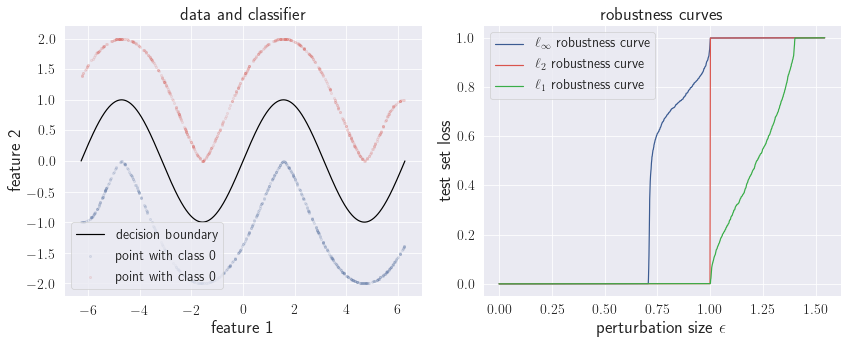

In [9]:
save_name = 'fig_rc_synthetic_data'

n_rows = 1
n_cols = 2
fig, axx = plt.subplots(n_rows,
                        n_cols,
                        figsize=(12,5))

ax = axx[0]
ax.plot(X, Y, c='black', label="decision boundary")
ax.scatter(points[labels, 0],
           points[labels, 1],
           c=colors["blue"],
           alpha=0.11,
           s=5,
           label="point with class 0")
ax.scatter(points[np.logical_not(labels), 0],
           points[np.logical_not(labels), 1],
           c=colors["red"],
           alpha=0.11,
           s=5,
           label="point with class 0")
ax.set_title("data and classifier")
ax.set_xlabel("feature 1")
ax.set_ylabel("feature 2")
ax.legend()

ax = axx
alpha = 1.0
ax[1].plot(dists_linf,
           probs,
           c=colors["blue"],
           alpha=alpha,
           label="$\ell_{\infty}$ robustness curve")
ax[1].plot(dists_l2,
           probs,
           c=colors["red"],
           alpha=alpha,
           label="$\ell_{2}$ robustness curve")
ax[1].plot(dists_l1,
           probs,
           c=colors["green"],
           alpha=alpha,
           label="$\ell_{1}$ robustness curve")
ax[1].set_xlabel("perturbation size $\epsilon$")
ax[1].set_ylabel("test set loss")
ax[1].set_title("robustness curves")
ax[1].legend()

fig.tight_layout()
fig.savefig('res/{}.pdf'.format(save_name))